# Obtenção da Imagem virtual por relação com o algoritmo do SIFT

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def stitch_rect_image(camera,mtx_1,dist_1,mtx_2,dist_2):
    # Load the images
    img1 = cv2.imread(f'./images_to_virtual/image{camera}/image_1_{camera}.jpg', 1)  # color
    img2 = cv2.imread(f'./images_to_virtual/image{camera}/image_2_{camera}.jpg', 1)  # color

    h_1,  w_1 = img1.shape[:2]
    newcameramtx_1, roi_1 = cv2.getOptimalNewCameraMatrix(mtx_1, dist_1, (w_1,h_1), 1, (w_1,h_1))

    # undistort
    dst_1 = cv2.undistort(img1, mtx_1, dist_1, None, newcameramtx_1)
    # crop the image
    x, y, w, h = roi_1
    dst_1 = dst_1[y:y+h, x:x+w]
    #cv2.imwrite('calibresult.png', dst)

    h_2,  w_2 = img2.shape[:2]
    newcameramtx_2, roi_2 = cv2.getOptimalNewCameraMatrix(mtx_2, dist_2, (w_2,h_2), 1, (w_2,h_2))

    # undistort
    dst_2 = cv2.undistort(img2, mtx_2, dist_2, None, newcameramtx_2)
    # crop the image
    x, y, w, h = roi_2
    dst_2 = dst_2[y:y+h, x:x+w]
    #cv2.imwrite('calibresult.png', dst)
    
    # Initialize SIFT detector
    sift = cv2.xfeatures2d.SIFT_create()

    # Find keypoints and descriptors with SIFT
    kp1, des1 = sift.detectAndCompute(dst_1, None)
    kp2, des2 = sift.detectAndCompute(dst_2, None)

    # Match features using FLANN (Fast Library for Approximate Nearest Neighbors)
    FLANN_INDEX_KDTREE = 0
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Store all the good matches as per Lowe's ratio test
    good = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good.append(m)

    src,dst = [],[]
    # Homography
    if len(good) > 10:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good]).reshape(-1, 1, 2)
        src.append(src_pts)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good]).reshape(-1, 1, 2)
        dst.append(dst_pts)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        # Get the size of the resulting stitched image
        h1, w1 = dst_1.shape[:2]
        h2, w2 = dst_2.shape[:2]
        corners1 = np.float32([[0, 0], [0, h1], [w1, h1], [w1, 0]]).reshape(-1, 1, 2)
        corners2 = np.float32([[0, 0], [0, h2], [w2, h2], [w2, 0]]).reshape(-1, 1, 2)
        corners2_transformed = cv2.perspectiveTransform(corners2, M)
        corners = np.concatenate((corners1, corners2_transformed), axis=0)

        [xmin, ymin] = np.int32(corners.min(axis=0).ravel() - 0.5)
        [xmax, ymax] = np.int32(corners.max(axis=0).ravel() + 0.5)
        translation = -np.float32([xmin, ymin])
        H_translation = np.array([[1, 0, translation[0]], [0, 1, translation[1]], [0, 0, 1]])

        # Stitch the images together
        result = cv2.warpPerspective(dst_1, H_translation @ M, (xmax - xmin, ymax - ymin))
        result[int(translation[1]):h2 + int(translation[1]), int(translation[0]):w2 + int(translation[0])] = dst_2

    else:
        print("Not enough matches are found - %d/%d" % (len(good), 10))
        matchesMask = None

    # Show the result
    cv2.imshow('Result', result)
    cv2.waitKey(0)
    cv2.destroyAllWindows()
    return result,src,dst

Definindo mtx_1 ... etc do código anterior para teste

In [7]:
mtx_1 = np.array([[999.61846853,   0.,         217.2324828 ],
 [  0.,         997.58793234, 223.2101505 ],
 [  0.,           0.,           1.        ]])

dist_1 = np.array([[-0.14508958, -0.09740103,  0.00095321, -0.00344546,  0.12604606]])

mtx_2 = np.array([[1.00783570e+03, 0.00000000e+00, 2.72030623e+02],
 [0.00000000e+00, 1.00546347e+03, 2.54104646e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

dist_2 = np.array([[-2.11834165e-01,  3.03342912e-01,  3.78222480e-04, -1.85460909e-03,
  -1.82561076e+00]])
R = np.array([[ 0.95309353, -0.02996579, -0.30118894],
                [ 0.0280217,   0.99954925, -0.01077388],
                [ 0.30137603,  0.00182869,  0.95350362]])
T = np.array([[22.63433211],
 [ 0.5136282 ],
 [ 3.60799583]])

In [8]:
stitched_image_1,src_1,dst_1 = stitch_rect_image('1',mtx_1,dist_1,mtx_2,dist_2)
src_1 = src_1[0].reshape(80,2)
dst_1 = dst_1[0].reshape(80,2)
cv2.imwrite('./images_virtual/virtual_1.jpg',stitched_image_1)
stitched_image_2,src_2,dst_2 = stitch_rect_image('2',mtx_1,dist_1,mtx_2,dist_2)
src_2 = src_2[0].reshape(131,2)
dst_2 = dst_2[0].reshape(131,2)
cv2.imwrite('./images_virtual/virtual_2.jpg',stitched_image_2)
stitched_image_3,src_3,dst_3 = stitch_rect_image('3',mtx_1,dist_1,mtx_2,dist_2)
src_3 = src_3[0].reshape(104,2)
dst_3 = dst_3[0].reshape(104,2)
cv2.imwrite('./images_virtual/virtual_3.jpg',stitched_image_3)

True

In [ ]:
with open('./coleta_pontos_homologos/pontos_homologos.txt', 'w') as f:
    f.write('src_1 1:\n')
    f.write(str(src_1))
    f.write('\n')

    f.write('dst_1 2:\n')
    f.write(str(dst_1))
    f.write('\n')

    f.write('src_2 1:\n')
    f.write(str(src_2))
    f.write('\n')

    f.write('dst_2 2:\n')
    f.write(str(dst_2))
    f.write('\n')

    f.write('src_3 1:\n')
    f.write(str(src_3))
    f.write('\n')

    f.write('dst_3 2:\n')
    f.write(str(dst_3))
    f.write('\n')

# Triangulação e obtenção dos pontos

## Imagem 1

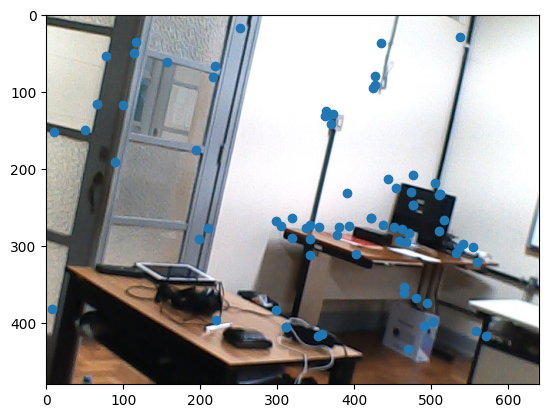

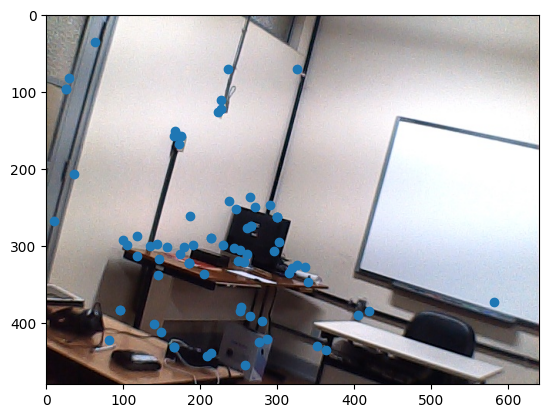

Triangulated point: 
[-5.81477579  3.8376239  27.64948673]
Triangulated point: 
[-7.59190603  1.17301515 35.59637192]
Triangulated point: 
[-8.25358774 -1.82634185 49.2340241 ]
Triangulated point: 
[-12.49747422   1.00099049  79.13235517]
Triangulated point: 
[-12.15845299  -1.58794012  82.18362662]
Triangulated point: 
[-5.17778274  2.00481745 39.41108009]
Triangulated point: 
[-8.1715891  -1.12180961 68.0504013 ]
Triangulated point: 
[-7.6149118  -3.589227   70.72911411]
Triangulated point: 
[-7.50424651 -4.12460021 71.26519829]
Triangulated point: 
[-6.40697537 -0.50408672 95.51943682]
Triangulated point: 
[ -6.40740408 -25.54790848 268.39815485]
Triangulated point: 
[ -6.18815974  14.26065083 317.38975469]
Triangulated point: 
[ -2.30852906   2.24826624 277.11419877]
Triangulated point: 
[ -0.50979532 -51.49581775 360.09742864]
Triangulated point: 
[  0.62504909 -56.41701192 358.77368812]
Triangulated point: 
[  0.49777575  32.69192328 190.09133422]
Triangulated point: 
[ 12.337726

In [9]:
uvs1 = src_1
uvs2 = dst_1
 
frame1 = cv2.imread('./images_to_virtual/image1/image_1_1.jpg')
frame2 = cv2.imread('./images_to_virtual/image1/image_2_1.jpg')
 
plt.imshow(frame1[:,:,[2,1,0]])
plt.scatter(uvs1[:,0], uvs1[:,1])
plt.show()
 
plt.imshow(frame2[:,:,[2,1,0]])
plt.scatter(uvs2[:,0], uvs2[:,1])
plt.show()
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx_1 @ RT1 #projection matrix for C1
 
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R, T], axis = -1)
P2 = mtx_2 @ RT2 #projection matrix for C2
def DLT(P1, P2, point1, point2):
 
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]
p3ds = []
for uv1, uv2 in zip(uvs1, uvs2):
    _p3d = DLT(P1, P2, uv1, uv2)
    p3ds.append(_p3d)
p3ds = np.array(p3ds)
np.savetxt('par 1.txt',p3ds,delimiter=',')

## Imagem 2

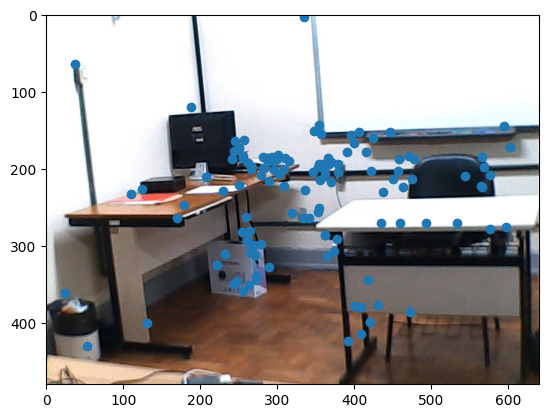

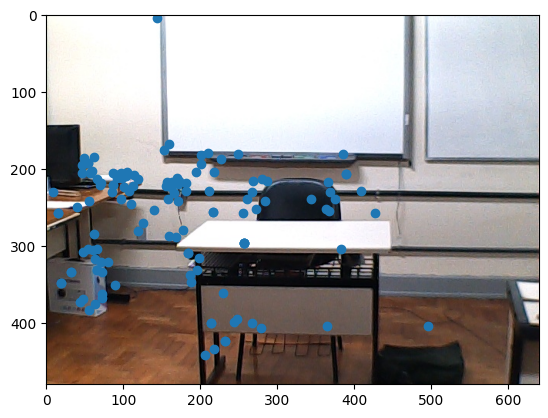

Triangulated point: 
[-15.74890067   8.08012723  81.37458111]
Triangulated point: 
[-9.39628999 -0.40414181 49.3164361 ]
Triangulated point: 
[-8.54067107  5.43951718 50.58047393]
Triangulated point: 
[-14.98626815   1.5221518  139.02196619]
Triangulated point: 
[-3.46926062  2.84574174 36.40466519]
Triangulated point: 
[-3.68430405  3.79656882 41.85716991]
Triangulated point: 
[ -5.28342096   3.4939148  109.51175016]
Triangulated point: 
[ -9.21745848   4.24659987 240.56141292]
Triangulated point: 
[-2.83431223 -0.30375909 90.59825586]
Triangulated point: 
[ -3.64617807  -5.07104995 385.21445227]
Triangulated point: 
[  1.38786125  38.87857243 385.62083187]
Triangulated point: 
[  1.38786125  38.87857243 385.62083187]
Triangulated point: 
[  4.3348565    1.77311649 342.97699498]
Triangulated point: 
[  5.48639414  32.67172394 380.14134251]
Triangulated point: 
[  5.48639414  32.67172394 380.14134251]
Triangulated point: 
[  9.12615859 -14.4871773  380.55715112]
Triangulated point: 
[ 

In [10]:
uvs1 = src_2
uvs2 = dst_2
 
frame1 = cv2.imread('./images_to_virtual/image2/image_1_2.jpg')
frame2 = cv2.imread('./images_to_virtual/image2/image_2_2.jpg')
 
plt.imshow(frame1[:,:,[2,1,0]])
plt.scatter(uvs1[:,0], uvs1[:,1])
plt.show()
 
plt.imshow(frame2[:,:,[2,1,0]])
plt.scatter(uvs2[:,0], uvs2[:,1])
plt.show()
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx_1 @ RT1 #projection matrix for C1
 
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R, T], axis = -1)
P2 = mtx_2 @ RT2 #projection matrix for C2
def DLT(P1, P2, point1, point2):
 
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]
p3ds = []
for uv1, uv2 in zip(uvs1, uvs2):
    _p3d = DLT(P1, P2, uv1, uv2)
    p3ds.append(_p3d)
p3ds = np.array(p3ds)
np.savetxt('par 2.txt',p3ds,delimiter=',')

## Imagem 3

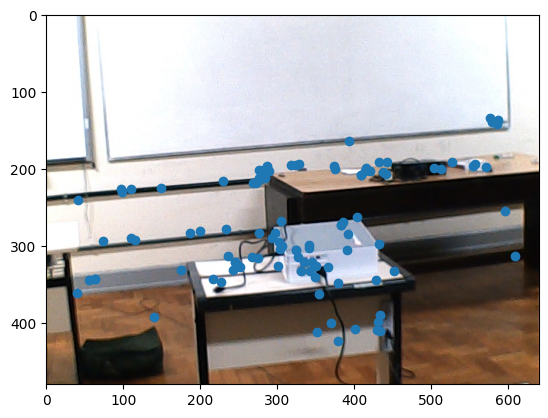

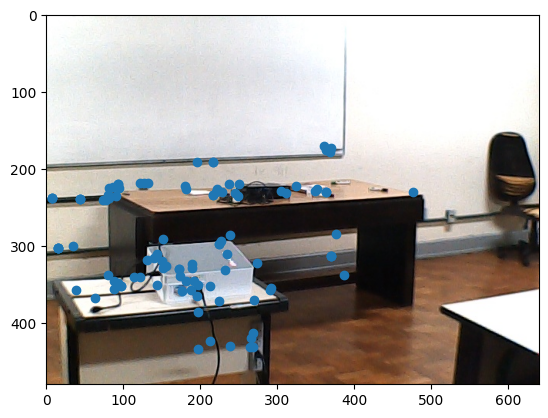

Triangulated point: 
[-9.86352991  2.21855572 53.88476848]
Triangulated point: 
[-9.68484163 -1.03655945 54.55939746]
Triangulated point: 
[-6.64093557  3.68961129 40.81639251]
Triangulated point: 
[-6.40512575  3.7198807  41.36786554]
Triangulated point: 
[-6.40512575  3.7198807  41.36786554]
Triangulated point: 
[-16.31604722   7.14963348 113.41518946]
Triangulated point: 
[-16.24707934  -0.14903744 135.2716646 ]
Triangulated point: 
[-1.35217322e+01  5.05344550e-02  1.12826135e+02]
Triangulated point: 
[-15.726311    -0.24041316 145.9648841 ]
Triangulated point: 
[-14.87070443   8.46176016 138.49872625]
Triangulated point: 
[-12.64031373   3.92888052 123.11861636]
Triangulated point: 
[-3.0888941   2.77563426 38.75734618]
Triangulated point: 
[-10.38880425  -0.2758174  150.30668732]
Triangulated point: 
[ -4.59978392   9.71022315 109.50552309]
Triangulated point: 
[ -8.05040618  14.76753792 256.83360961]
Triangulated point: 
[ -5.26937759  17.32493598 305.08911453]
Triangulated poin

In [11]:
uvs1 = src_3
uvs2 = dst_3
 
frame1 = cv2.imread('./images_to_virtual/image3/image_1_3.jpg')
frame2 = cv2.imread('./images_to_virtual/image3/image_2_3.jpg')
 
plt.imshow(frame1[:,:,[2,1,0]])
plt.scatter(uvs1[:,0], uvs1[:,1])
plt.show()
 
plt.imshow(frame2[:,:,[2,1,0]])
plt.scatter(uvs2[:,0], uvs2[:,1])
plt.show()
#RT matrix for C1 is identity.
RT1 = np.concatenate([np.eye(3), [[0],[0],[0]]], axis = -1)
P1 = mtx_1 @ RT1 #projection matrix for C1
 
#RT matrix for C2 is the R and T obtained from stereo calibration.
RT2 = np.concatenate([R, T], axis = -1)
P2 = mtx_2 @ RT2 #projection matrix for C2
def DLT(P1, P2, point1, point2):
 
    A = [point1[1]*P1[2,:] - P1[1,:],
         P1[0,:] - point1[0]*P1[2,:],
         point2[1]*P2[2,:] - P2[1,:],
         P2[0,:] - point2[0]*P2[2,:]
        ]
    A = np.array(A).reshape((4,4))
    #print('A: ')
    #print(A)
 
    B = A.transpose() @ A
    from scipy import linalg
    U, s, Vh = linalg.svd(B, full_matrices = False)
 
    print('Triangulated point: ')
    print(Vh[3,0:3]/Vh[3,3])
    return Vh[3,0:3]/Vh[3,3]
p3ds = []
for uv1, uv2 in zip(uvs1, uvs2):
    _p3d = DLT(P1, P2, uv1, uv2)
    p3ds.append(_p3d)
p3ds = np.array(p3ds)
np.savetxt('par 3.txt',p3ds,delimiter=',')